In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [60]:
#choppeddata=pd.read_csv('choppeddata_10_06_2021.csv')#.head()
choppeddata=pd.read_csv('choppeddata_10_06_2021_equalsuccessfail.csv')#.head()

print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(3960, 10)
total runs: 660


In [61]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print(X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
print("Train")
print(train_x[0])
print(train_y[0])
print("Train set Y size", train_y.size)
print("Test")
print(test_x[0])
print(test_y[0])
print("Test set Y size", test_y.size)

(660, 5, 10)
Train
[[0.80341493 0.7873078  0.80515439 0.80361194 0.78515806 0.81005521
  0.79144821 0.79869703 0.79140041 0.79122547]
 [0.52339347 0.50429968 0.52072033 0.53725302 0.51505935 0.53641852
  0.5209503  0.53046722 0.53482735 0.55204404]
 [0.95582798 0.93583265 0.94561755 0.94143152 0.96061182 0.94571884
  0.95856004 0.94630694 0.95613787 0.93519259]
 [0.45328507 0.46789607 0.45826216 0.45043368 0.46666419 0.44726744
  0.46281977 0.45020456 0.45228556 0.44095337]
 [0.82153411 0.80648105 0.81638549 0.81204331 0.80326888 0.81557581
  0.80576011 0.80899312 0.80871971 0.80237905]]
[0.]
Train set Y size 495
Test
[[0.55207911 0.54107505 0.52676553 0.51657558 0.50454249 0.50611889
  0.50834637 0.52264127 0.5284617  0.6188375 ]
 [0.57429489 0.56697588 0.59204713 0.55749768 0.5833457  0.57061302
  0.57714088 0.56112191 0.62597133 0.61400177]
 [0.9520256  0.9533232  0.94150557 0.95599422 0.94731364 0.93071741
  0.93639073 0.95289178 0.95189235 0.94066496]
 [0.45987288 0.46099478 0.441

We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [62]:
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


In [63]:
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [64]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [65]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

def evaluatefull(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )


In [53]:
print(100*5/80)
print(int(100*5/80))

6.25
6


Starting Training of GRU model
Epoch 40/400 Done, Total Loss: 0.06261666670273157   Time Elapsed: 0.2575600000000122 seconds
Epoch 80/400 Done, Total Loss: 0.026726211213205783   Time Elapsed: 0.26162699999986216 seconds
Epoch 120/400 Done, Total Loss: 0.015803412140389182   Time Elapsed: 0.2886909999999716 seconds
Epoch 160/400 Done, Total Loss: 0.01672968377344541   Time Elapsed: 0.2646879999999783 seconds
Epoch 200/400 Done, Total Loss: 0.013492619792568286   Time Elapsed: 0.2678319999999985 seconds
Epoch 240/400 Done, Total Loss: 0.008768334937101132   Time Elapsed: 0.26448899999991227 seconds
Epoch 280/400 Done, Total Loss: 0.008310726373913089   Time Elapsed: 0.266399999999976 seconds
Epoch 320/400 Done, Total Loss: 0.0036634116011377846   Time Elapsed: 0.26448099999993246 seconds
Epoch 360/400 Done, Total Loss: 0.005687677761981343   Time Elapsed: 0.2723839999998745 seconds
Epoch 400/400 Done, Total Loss: 0.001865237581003429   Time Elapsed: 0.2605750000000171 seconds
Total Trai

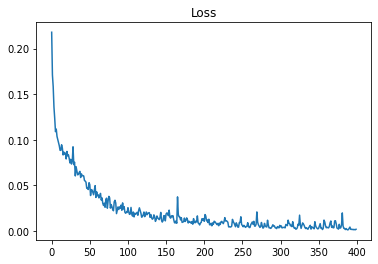

Vs Training Set
Evaluation Time: 0.0014510000000882428
sMAPE: 1.1370328869847777%
0.022448272
Vs Test Set
Evaluation Time: 0.0008330000000569271
sMAPE: 11.395758103463473%

 vs training data= 494 / 495  vs test data= 131 / 165 79 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.0010039999999662541
sMAPE: 1.1370328869847777%
0.022448272
Vs Test Set
Evaluation Time: 0.0005989999999655993
sMAPE: 11.395758103463473%

 vs training data= 495 / 495  vs test data= 138 / 165 83 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.001563999999916632
sMAPE: 1.1370328869847777%
0.022448272
Vs Test Set
Evaluation Time: 0.0007760000000871514
sMAPE: 11.395758103463473%

 vs training data= 495 / 495  vs test data= 140 / 165 84 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.0017960000000130094
sMAPE: 1.1370328869847777%
0.022448272
Vs Test Set
Evaluation Time: 0.000730999999859705
sMAPE: 11.395758103463473%

 vs training data= 495 / 495  vs test data= 144 / 165 87 % at max d

In [66]:
lr = 0.001
gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=400, model_type="GRU")
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)
#vs training data= 490 / 495  vs test data= 128 / 165 (77%) from 128 hidden dim,  batch size of 4, lr =0.001,test_size=.25,  400 epoch
#vs training data= 492 / 495  vs test data= 130 / 165 (78%) from 128 hidden dim,  batch size of 4, lr =0.0005,test_size=.25,  400 epoch
#vs training data= 411 / 495  vs test data= 103 / 165 62%) from 128 hidden dim,  batch size of 4, lr =0.0001,test_size=.25,  400 epoch
#vs training data= 451 / 495  vs test data= 113 / 165 68%) from 128 hidden dim,  batch size of 4, lr =0.0001,test_size=.25,  600 epoch
#vs training data= 472 / 495  vs test data= 133 / 165 80%) from 128 hidden dim,  batch size of 4, lr =0.002,test_size=.25,  600 epoch


#vs training data= 472 / 495  vs test data= 133 / 165 80%) from 128 hidden dim,  batch size of 4, lr =0.002,test_size=.25,  400 epoch
#vs training data= 487 / 495  vs test data= 134 / 165 81% at 0.2 cuttoff
 #vs training data= 490 / 495  vs test data= 142 / 165 86.06060606060606 % at 0.3 cuttoff
 # vs training data= 491 / 495  vs test data= 146 / 165 88.48484848484848 % at 0.4 cuttoff






#With full data set (uneven amts of success/fail) from 128 hidden dim,  batch size of 4, lr =0.0005,test_size=.25,  400 epoch
#vs training data= 893 / 900  vs test data= 227 / 300 75 % at max difference 0.2
# vs training data= 898 / 900  vs test data= 238 / 300 79 % at max difference 0.3
# vs training data= 900 / 900  vs test data= 240 / 300 80 % at max difference 0.4
# vs training data= 900 / 900  vs test data= 243 / 300 81 % at max difference 0.5


#with even success/fail amounts:

# vs training data= 494 / 495  vs test data= 131 / 165 79 % at max difference 0.2
# vs training data= 495 / 495  vs test data= 138 / 165 83 % at max difference 0.3
# vs training data= 495 / 495  vs test data= 140 / 165 84 % at max difference 0.4
# vs training data= 495 / 495  vs test data= 144 / 165 87 % at max difference 0.5


#The target size means the label size!

In [59]:
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)#,verbose=True)

Vs Training Set
Evaluation Time: 0.010782000000062908
sMAPE: -2.6715693007246553%
-0.006552458
Vs Test Set
Evaluation Time: 0.0007630000000062864
sMAPE: 10.777743848216746%

 vs training data= 893 / 900  vs test data= 227 / 300 75 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.0018829999999070424
sMAPE: -2.6715693007246553%
-0.006552458
Vs Test Set
Evaluation Time: 0.0007460000001628941
sMAPE: 10.777743848216746%

 vs training data= 898 / 900  vs test data= 238 / 300 79 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.0018939999999929569
sMAPE: -2.6715693007246553%
-0.006552458
Vs Test Set
Evaluation Time: 0.0007259999999860156
sMAPE: 10.777743848216746%

 vs training data= 900 / 900  vs test data= 240 / 300 80 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.001856999999972686
sMAPE: -2.6715693007246553%
-0.006552458
Vs Test Set
Evaluation Time: 0.000722999999879903
sMAPE: 10.777743848216746%

 vs training data= 900 / 900  vs test data= 243 / 300 81 % a

In [ ]:
model=gru_model
i=1
inp = torch.from_numpy(np.array(test_x))
labs = torch.from_numpy(np.array(test_y))
#h = model.init_hidden(inp.shape[0])
h = model.init_hidden(inp.shape[0])
#print("inp",inp)

#print("INP SHAPE",inp.shape)
#print("INP SHAPE[0]",inp.shape[0])
#print("labs",labs)
#print("h",h)
#print("h.shape",h.shape)
#print(inp.to(device).float())
#print(inp.to(device).float().shape)
print(inp.to(device).float().shape)

out, h = model(inp.to(device).float(), h)
#print(out)

In [ ]:
i=0    
print(testy[i])
print(gru_outputs[0][i])
print(np.abs(testy[i]-gru_outputs[0][i]))
print(np.abs(testy[i]-gru_outputs[0][i])<0.2)

print(trainy[i],gru_outputs[0][i] )

"""
if np.abs(testy[i]-gru_outputs[0][i])<0.2 :
   
    print(trainy[i],gru_outputs[0][i], "OK" )
else:
    print(trainy[i],gru_outputs[0][i], "X" )
    

if 0.0-0.91831344>0.2 :
    print("ok")
"""

In [ ]:
#print(test_y.reshape(-1))
